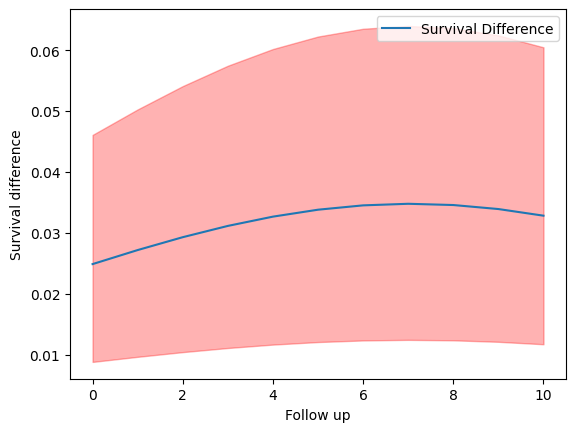

In [17]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: Setup
trial_pp = {"estimand": "PP"}  # Per-protocol
trial_itt = {"estimand": "ITT"}  # Intention-to-treat

# Create directories to save files
trial_pp_dir = os.path.join(os.getcwd(), "trial_pp")
trial_itt_dir = os.path.join(os.getcwd(), "trial_itt")
os.makedirs(trial_pp_dir, exist_ok=True)
os.makedirs(trial_itt_dir, exist_ok=True)

# Step 2: Data Preparation
# Load dataset
data_censored = pd.read_csv("data_censored.csv")

# Assigning data to trials
for trial in [trial_pp, trial_itt]:
    trial["data"] = data_censored.copy()
    trial["id"] = "id"
    trial["period"] = "period"
    trial["treatment"] = "treatment"
    trial["outcome"] = "outcome"
    trial["eligible"] = "eligible"

# Step 3.1: Censoring due to treatment switching (Only for PP)
def fit_logistic_regression(X, y):
    model = LogisticRegression()
    model.fit(X, y)
    return model

trial_pp["switch_weight_model"] = {
    "numerator": ["age"],
    "denominator": ["age", "x1", "x3"],
    "model_fitter": lambda X, y: fit_logistic_regression(X, y)
}

# Step 3.2: Other informative censoring (Both PP and ITT)
def set_censor_weight_model(trial, pool_models):
    trial["censor_weight_model"] = {
        "censor_event": "censored",
        "numerator": ["x2"],
        "denominator": ["x2", "x1"],
        "pool_models": pool_models
    }

set_censor_weight_model(trial_pp, "none")
set_censor_weight_model(trial_itt, "numerator")

# Step 4: Calculate Weights
def calculate_weights(trial):
    # Calculate stabilized weights for treatment switching (PP only)
    if trial["estimand"] == "PP":
        # Numerator model (marginal probability of treatment)
        X_numerator = trial["data"][trial["switch_weight_model"]["numerator"]]
        y_numerator = trial["data"]["treatment"]
        numerator_model = trial["switch_weight_model"]["model_fitter"](X_numerator, y_numerator)
        numerator_probs = numerator_model.predict_proba(X_numerator)[:, 1]

        # Denominator model (probability of treatment given covariates)
        X_denominator = trial["data"][trial["switch_weight_model"]["denominator"]]
        y_denominator = trial["data"]["treatment"]
        denominator_model = trial["switch_weight_model"]["model_fitter"](X_denominator, y_denominator)
        denominator_probs = denominator_model.predict_proba(X_denominator)[:, 1]

        # Calculate stabilized weights
        trial["data"]["switch_weights"] = numerator_probs / denominator_probs

    # Calculate stabilized weights for censoring (both PP and ITT)
    X_numerator_censor = trial["data"][trial["censor_weight_model"]["numerator"]]
    y_numerator_censor = 1 - trial["data"][trial["censor_weight_model"]["censor_event"]]
    numerator_censor_model = LogisticRegression().fit(X_numerator_censor, y_numerator_censor)
    numerator_censor_probs = numerator_censor_model.predict_proba(X_numerator_censor)[:, 1]

    X_denominator_censor = trial["data"][trial["censor_weight_model"]["denominator"]]
    y_denominator_censor = 1 - trial["data"][trial["censor_weight_model"]["censor_event"]]
    denominator_censor_model = LogisticRegression().fit(X_denominator_censor, y_denominator_censor)
    denominator_censor_probs = denominator_censor_model.predict_proba(X_denominator_censor)[:, 1]

    # Calculate stabilized censoring weights
    trial["data"]["censor_weights"] = numerator_censor_probs / denominator_censor_probs

    # Combine weights (if applicable)
    if trial["estimand"] == "PP":
        trial["data"]["weights"] = trial["data"]["switch_weights"] * trial["data"]["censor_weights"]
    else:
        trial["data"]["weights"] = trial["data"]["censor_weights"]

    # Winsorize weights to handle extreme values
    q99 = np.quantile(trial["data"]["weights"], 0.99)
    trial["data"]["weights"] = np.minimum(trial["data"]["weights"], q99)

    trial["weights_calculated"] = True
    return trial

trial_pp = calculate_weights(trial_pp)
trial_itt = calculate_weights(trial_itt)

# Step 5: Specify Outcome Model
trial_pp["outcome_model"] = {}
trial_itt["outcome_model"] = {"adjustment_terms": ["x2"]}

# Step 6: Expand Trials
def expand_trials(trial, chunk_size=500):
    trial["expansion"] = {
        "chunk_size": chunk_size,
        "censor_at_switch": True,
        "first_period": 0,
        "last_period": float("inf"),
        "expanded_data": trial["data"].copy()
    }
    return trial

trial_pp = expand_trials(trial_pp)
trial_itt = expand_trials(trial_itt)

# Step 7: Load or Sample from Expanded Data
def load_expanded_data(trial, seed=1234, p_control=1.0, period_range=None, subset_condition=None):
    expanded_data = trial["expansion"]["expanded_data"].copy()
    
    if seed is not None:
        np.random.seed(seed)
    
    if period_range is not None:
        expanded_data = expanded_data[expanded_data["period"].between(period_range[0], period_range[1])]
    
    if subset_condition:
        expanded_data = expanded_data.query(subset_condition)
    
    if p_control < 1.0:
        control_group = expanded_data[expanded_data["outcome"] == 0]
        treated_group = expanded_data[expanded_data["outcome"] != 0]
        sampled_control = control_group.sample(frac=p_control, random_state=seed)
        expanded_data = pd.concat([sampled_control, treated_group])
    
    # Ensure required columns exist
    if "assigned_treatment" not in expanded_data.columns:
        expanded_data["assigned_treatment"] = expanded_data["treatment"]  # Map "treatment" to "assigned_treatment"
    
    if "followup_time" not in expanded_data.columns:
        expanded_data["followup_time"] = expanded_data["period"]  # Map "period" to "followup_time"
    
    trial["loaded_data"] = expanded_data
    return trial

# Load expanded data for ITT trial
trial_itt = load_expanded_data(trial_itt, seed=1234, p_control=0.5)

# Step 8: Fit Marginal Structural Model
def fit_msm(trial, weight_cols):
    data = trial["loaded_data"].copy()
    
    # Check if weight columns exist in the DataFrame
    missing_cols = [col for col in weight_cols if col not in data.columns]
    if missing_cols:
        raise KeyError(f"The following weight columns are missing: {missing_cols}")
    
    # Calculate the combined weight as the product of specified weight columns
    data["weight"] = data[weight_cols].prod(axis=1)
    
    # Winsorization of extreme weights (cap at the 99th percentile)
    q99 = np.quantile(data["weight"], 0.99)
    data["weight"] = np.minimum(data["weight"], q99)
    
    # Ensure required columns exist in the DataFrame
    required_columns = ["assigned_treatment", "x2", "followup_time", "period", "outcome"]
    missing_columns = [col for col in required_columns if col not in data.columns]
    if missing_columns:
        raise KeyError(f"The following required columns are missing: {missing_columns}")
    
    # Prepare features for the model
    X = data[["assigned_treatment", "x2", "followup_time"]].copy()
    X["followup_time^2"] = X["followup_time"] ** 2
    X["trial_period"] = data["period"]
    X["trial_period^2"] = X["trial_period"] ** 2
    y = data["outcome"]
    
    # Fit the logistic regression model with weights
    model = LogisticRegression()
    model.fit(X, y, sample_weight=data["weight"])
    
    # Store the fitted model in the trial object
    trial["outcome_model"] = model
    return trial

# Use the correct weight column name
trial_itt = fit_msm(trial_itt, weight_cols=["weights"])  # Use "weights" instead of ["weight", "sample_weight"]

# Step 9: Inference
def predict_survival(trial, predict_times=range(11)):
    model = trial["outcome_model"]
    data = trial["loaded_data"].copy()
    
    preds = {
        "followup_time": [],
        "survival_diff": [],
        "2.5%": [],
        "97.5%": []
    }
    
    for t in predict_times:
        # Update followup_time and derived features
        data["followup_time"] = t
        data["followup_time^2"] = data["followup_time"] ** 2
        data["trial_period"] = data["period"]
        data["trial_period^2"] = data["trial_period"] ** 2
        
        # Prepare features for prediction
        X = data[["assigned_treatment", "x2", "followup_time", "followup_time^2", "trial_period", "trial_period^2"]]
        
        # Predict survival probabilities
        survival_probs = model.predict_proba(X)[:, 1]
        
        # Store results
        preds["followup_time"].append(t)
        preds["survival_diff"].append(np.mean(survival_probs))
        preds["2.5%"].append(np.percentile(survival_probs, 2.5))
        preds["97.5%"].append(np.percentile(survival_probs, 97.5))
    
    return preds

# Generate predictions
preds = predict_survival(trial_itt)

# Plot results
plt.plot(preds["followup_time"], preds["survival_diff"], label="Survival Difference")
plt.fill_between(preds["followup_time"], preds["2.5%"], preds["97.5%"], color='red', alpha=0.3)
plt.xlabel("Follow up")
plt.ylabel("Survival difference")
plt.legend()
plt.show()